In [1]:
import numpy as np
import pandas as pd
import overpy
import geopandas as gpd
import ee
from geetools import batch
import requests
from shapely.geometry import Polygon, box, Point
import os
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
from shapely import wkt
import seaborn as sns



## OpenStreetMap API

In [2]:
api = overpy.Overpass()

# Fetch all wastewater treatment plants within California's boundary
query = f"""
    area[admin_level=4]["name"="California"]->.searchArea;
    (
      way["man_made"="wastewater_plant"](area.searchArea);
    );
    (._;>;);
    out body;
    """

result = api.query(query)

# Store results in desired format
plants = {}

for way in result.ways:
    # Use the name of the plant or its ID if the name is not available
    plant_name = way.tags.get("name", f"Plant_{way.id}")

    # Extract nodes lat and lon without id
    nodes_coords = [(node.lon, node.lat) for node in way.nodes]

    # get rid of "Decimal"  in the coordinates
    nodes_coords = [tuple(map(float, i)) for i in nodes_coords]
    
    plants[plant_name] = nodes_coords


In [3]:
geoms = [Polygon(plants[key]) for key in plants]
df = gpd.GeoDataFrame({'WWTP_name': list(plants.keys()), 'geometry': geoms}, crs="EPSG:4326")
df

,WWTP_name,geometry
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6..."
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8..."
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8..."
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9..."
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4..."
...,...,...
3102,Plant_1223090231,"POLYGON ((-122.89955 38.24430, -122.89956 38.2..."
3103,Plant_1223674336,"POLYGON ((-120.68759 35.64798, -120.68756 35.6..."
3104,Plant_1223674337,"POLYGON ((-120.68721 35.64812, -120.68719 35.6..."
3105,Plant_1223674338,"POLYGON ((-120.68736 35.64840, -120.68734 35.6..."


In [4]:
df["centroid"] = df.to_crs('+proj=cea').centroid.to_crs(epsg=4326)

In [5]:
df

,WWTP_name,geometry,centroid
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6...",POINT (-121.80762 37.69120)
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8...",POINT (-121.78025 36.79990)
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8...",POINT (-122.29525 37.82512)
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9...",POINT (-118.43006 33.92574)
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4...",POINT (-121.94663 37.43156)
...,...,...,...
3102,Plant_1223090231,"POLYGON ((-122.89955 38.24430, -122.89956 38.2...",POINT (-122.89878 38.24382)
3103,Plant_1223674336,"POLYGON ((-120.68759 35.64798, -120.68756 35.6...",POINT (-120.68767 35.64806)
3104,Plant_1223674337,"POLYGON ((-120.68721 35.64812, -120.68719 35.6...",POINT (-120.68730 35.64820)
3105,Plant_1223674338,"POLYGON ((-120.68736 35.64840, -120.68734 35.6...",POINT (-120.68745 35.64848)


## Concat lists

In [6]:
df_yz_yes = pd.read_excel('YZ_Yes.xlsx')
df_yz_yes_maybe = pd.read_excel('YZ_Yes_and_Maybe.xlsx')

df_dy_yes = pd.read_excel('DY_Yes.xlsx')
df_dy_yes_maybe = pd.read_excel('DY_Yes_and_Maybe.xlsx')

df_ss_yes_maybe = pd.read_excel('SS_Maybe.xlsx')

df_pooja_yes = pd.read_excel('Pooja_Yes.xlsx')
df_pooja_yes_maybe = pd.read_excel('Pooja_Yes_and_Maybe.xlsx')

df_original_missing_yes = pd.read_excel('Original_Missing_Yes.xlsx')
df_original_missing_yes_maybe = pd.read_excel('Original_Missing_Yes_and_Maybe.xlsx')

In [7]:
# concat all yes and all yes_and_maybe
df_yes = pd.concat([df_yz_yes, df_dy_yes, df_pooja_yes, df_original_missing_yes])
df_yes.reset_index(drop=True, inplace=True)
df_yes_maybe = pd.concat([df_yz_yes_maybe, df_dy_yes_maybe, df_ss_yes_maybe, df_pooja_yes_maybe, df_original_missing_yes_maybe])
df_yes_maybe = df_yes_maybe.iloc[:,:1]
df_yes_maybe.reset_index(drop=True, inplace=True)

print(f"Number of plants in yes: {len(df_yes)}")
print(f"Number of plants in yes_maybe: {len(df_yes_maybe)}")

Number of plants in yes: 119
Number of plants in yes_maybe: 306


In [8]:
gdf_yes = df.loc[df['WWTP_name'].isin(df_yes['filename'])]
gdf_yes_maybe = df.loc[df['WWTP_name'].isin(df_yes_maybe['filename'])]

print(f"Number of plants in yes: {len(gdf_yes)}")
print(f"Number of plants in yes_maybe: {len(gdf_yes_maybe)}")

Number of plants in yes: 115
Number of plants in yes_maybe: 299


In [9]:
# # save to csv
# gdf_yes.to_csv('gdf_Yes.csv')
# gdf_yes_maybe.to_csv('gdf_Yes_and_Maybe.csv')

## Plotting

In [10]:
# visualize the centroid of the plants in the map
import folium
import branca
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# Create a map
m = folium.Map(location=[37, -120], zoom_start=6)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_yes.iterrows():
    mc.add_child(folium.Marker(location=[row['centroid'].y, row['centroid'].x]))
m.add_child(mc)

# Display the map
m


In [11]:
# save as interactive html
m.save('CA_Yes.html')

In [12]:
# Create a map
m = folium.Map(location=[37, -120], zoom_start=6)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_yes_maybe.iterrows():
    mc.add_child(folium.Marker(location=[row['centroid'].y, row['centroid'].x]))
m.add_child(mc)

# Display the map
m


In [13]:
m.save('CA_Yes_Maybe.html')

## Static plots

In [14]:
gdf_yes_centroid = gdf_yes.loc[:, ['WWTP_name', 'centroid']]
# change centroid to geometry point
gdf_yes_centroid['geometry'] = gdf_yes_centroid['centroid'].apply(lambda x: Point(x))
gdf_yes_centroid.drop(columns=['centroid'], inplace=True)
gdf_yes_centroid.to_crs(epsg=4326, inplace=True)

gdf_yes_and_maybe_centroid = gdf_yes_maybe.loc[:, ['WWTP_name', 'centroid']]
# change centroid to geometry point
gdf_yes_and_maybe_centroid['geometry'] = gdf_yes_and_maybe_centroid['centroid'].apply(lambda x: Point(x))
gdf_yes_and_maybe_centroid.drop(columns=['centroid'], inplace=True)
gdf_yes_and_maybe_centroid.to_crs(epsg=4326, inplace=True)

In [15]:
df_christine = pd.read_excel('CA_VerifiedSolar_VerifiedLocation.xlsx')
df_christine = df_christine.loc[:, ['FacilityName', 'Lat, Long']]
df_christine['lat'] = df_christine['Lat, Long'].apply(lambda x: float(x.split(',')[0]))
df_christine['lon'] = df_christine['Lat, Long'].apply(lambda x: float(x.split(',')[1]))
df_christine.drop(columns=['Lat, Long'], inplace=True)

# convert to geodataframe
gdf_christine = gpd.GeoDataFrame(df_christine, geometry=gpd.points_from_xy(df_christine.lon, df_christine.lat))
gdf_christine.crs = 'epsg:4326'
gdf_christine.head()

,FacilityName,lat,lon,geometry
0,Alvarado WWTF,37.592371,-122.091334,POINT (-122.09133 37.59237)
1,AUBURN WWTF,38.888344,-121.109503,POINT (-121.10950 38.88834)
2,Bakersfield 2,35.325050,-118.967661,POINT (-118.96766 35.32505)
3,Bakersfield 3,35.325808,-118.973105,POINT (-118.97310 35.32581)
4,Chowchilla WWTP,37.104374,-120.260346,POINT (-120.26035 37.10437)


/home/codespace/.python/current/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


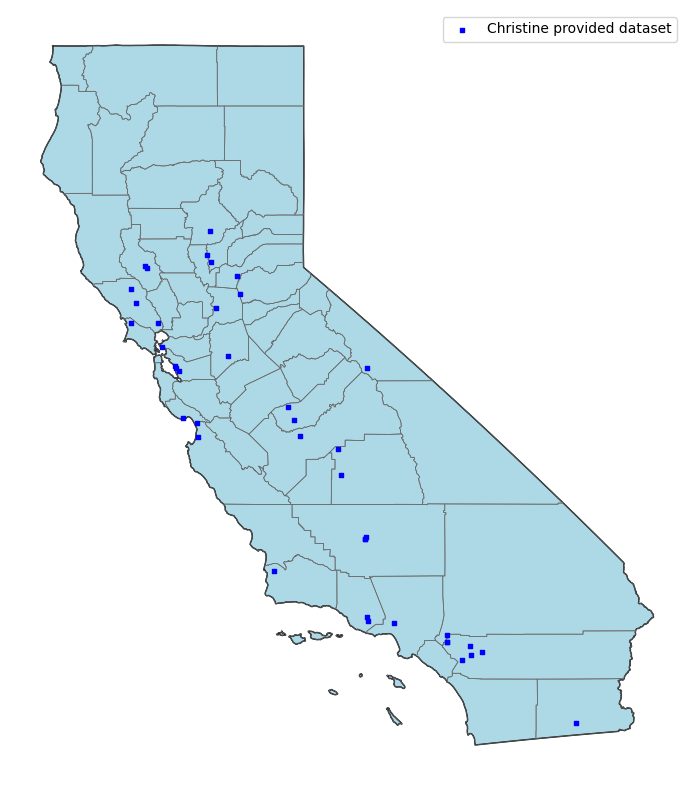

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

# URLs to shapefiles
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_5m.zip'
url_counties = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip'
url_places = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_place_500k.zip'

# Load data
states = gpd.read_file(url_state)
counties = gpd.read_file(url_counties)
places = gpd.read_file(url_places)

# Filter for California and its counties and places
california = states[states['STUSPS'] == 'CA']
ca_counties = counties[counties['STATEFP'] == '06']
california.to_crs(epsg=4326, inplace=True)
ca_counties.to_crs(epsg=4326, inplace=True)
ca_places = places[places['STATEFP'] == '06']


# Plot Christine's data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
# ca_places.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')

# Set title
plt.axis('off')
plt.legend()
plt.show()


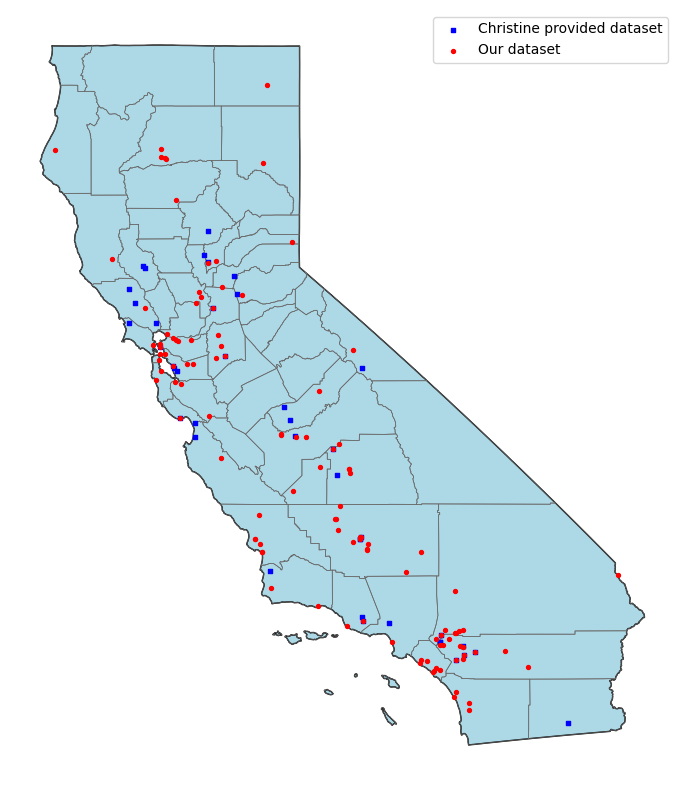

In [17]:
# Plot Christine's data and our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

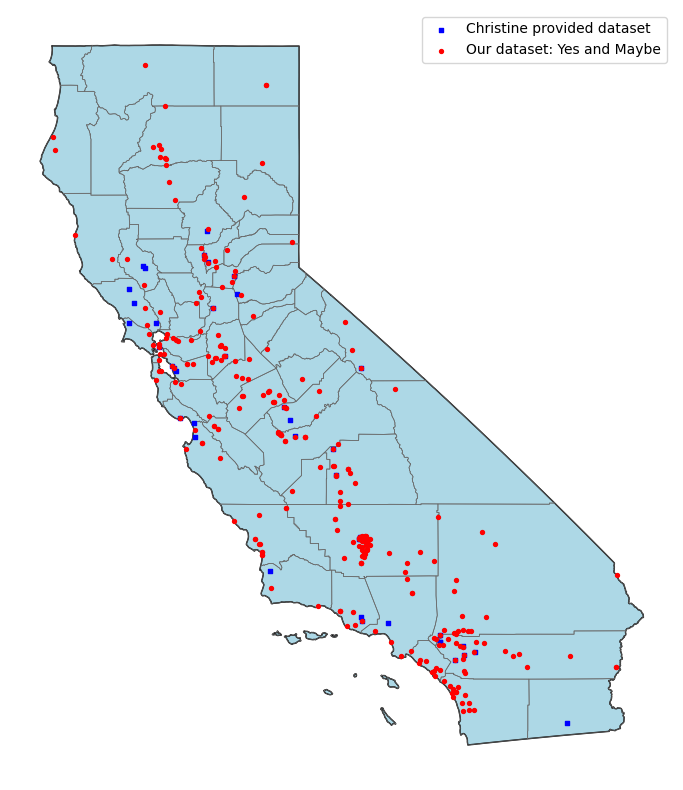

In [18]:
# Plot Christine's data and our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_and_maybe_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset: Yes and Maybe')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

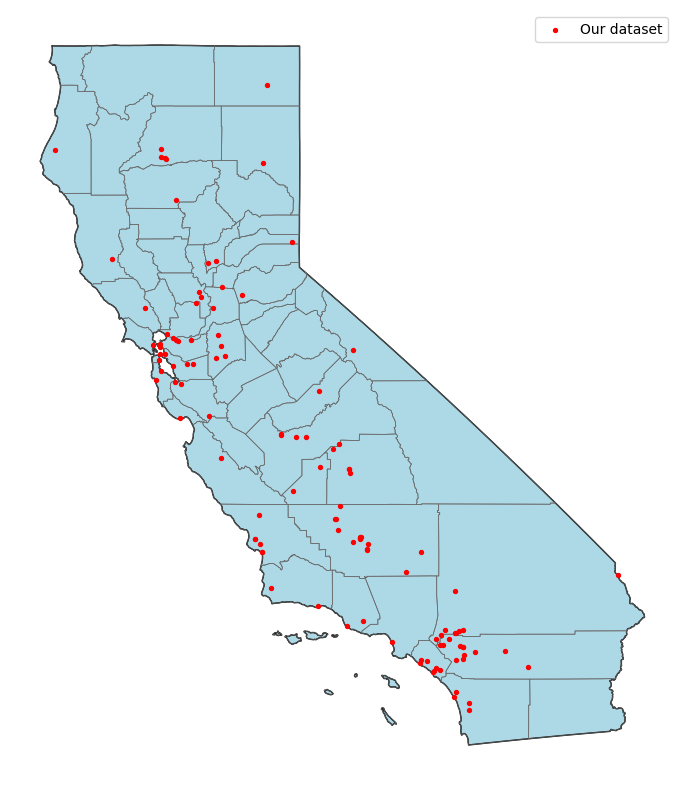

In [19]:
# Plot our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
# gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

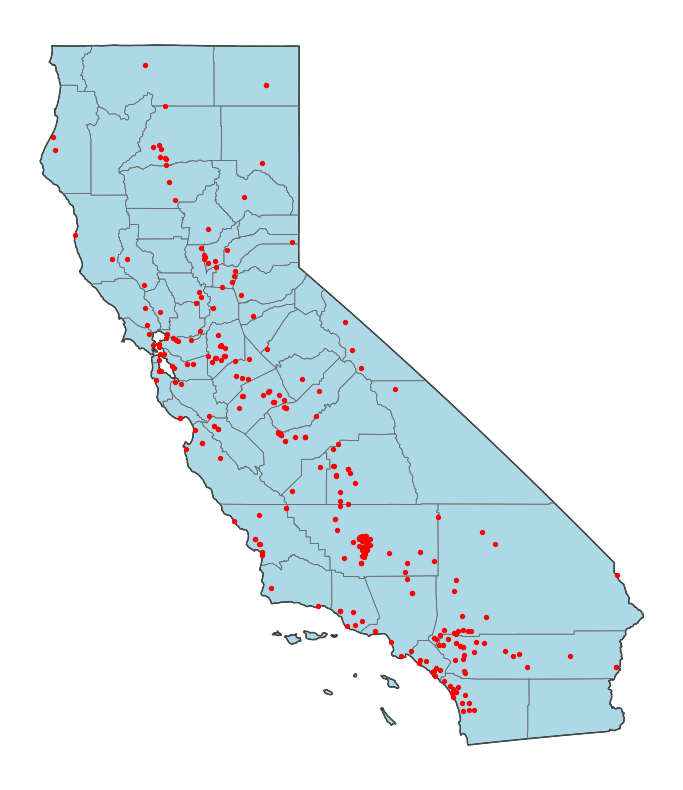

In [20]:
# Plot our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
# gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_and_maybe_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset')
# ax.legend()

# Set title
plt.axis('off')
# plt.legend()
plt.show()

## Revise the graph

In [21]:
gdf_yes_centroid.reset_index(drop=True, inplace=True)
gdf_yes_centroid

,WWTP_name,geometry
0,Plant_24298754,POINT (-121.80762 37.69120)
1,EBMUD Wastewater Treatment Plant,POINT (-122.29525 37.82512)
2,Hyperion Wastewater Treatment Plant,POINT (-118.43006 33.92574)
3,Sunnyvale Water Pollution Control Plant,POINT (-122.01527 37.41897)
4,Plant_30489168,POINT (-122.44459 37.47305)
...,...,...
110,La Salina Wastewater Treatment Plant,POINT (-117.36977 33.17915)
111,Coastal Treatment Plant,POINT (-117.73645 33.51808)
112,Shafter Waste Water Treatment Plant,POINT (-119.34593 35.44925)
113,Riverside Water Quality Control Plant,POINT (-117.45829 33.96266)


In [22]:
gdf_christine.head()

,FacilityName,lat,lon,geometry
0,Alvarado WWTF,37.592371,-122.091334,POINT (-122.09133 37.59237)
1,AUBURN WWTF,38.888344,-121.109503,POINT (-121.10950 38.88834)
2,Bakersfield 2,35.325050,-118.967661,POINT (-118.96766 35.32505)
3,Bakersfield 3,35.325808,-118.973105,POINT (-118.97310 35.32581)
4,Chowchilla WWTP,37.104374,-120.260346,POINT (-120.26035 37.10437)


In [23]:
import geopandas as gpd
from shapely.ops import nearest_points
from geopy.distance import geodesic

In [24]:
# Step 1: Ensure both GeoDataFrames have the same CRS
gdf_christine_1 = gdf_christine.to_crs(gdf_yes_centroid.crs)

# Step 2: Find the closest point in gdf_yes_centroid for each point in gdf_christine
def find_closest_point_attributes(row, other_gdf):
    # Find the nearest geometry using unary_union for efficiency
    nearest_geom = nearest_points(row.geometry, other_gdf.unary_union)[1]
    
    # Use the nearest geometry to find the corresponding row in the other GeoDataFrame
    closest_row = other_gdf.loc[other_gdf.geometry == nearest_geom]
    
    # Return the necessary attributes from the closest row
    # We assume that there is only one matching row, hence the use of iloc[0]
    return pd.Series({
        'closest_WWTP_name': closest_row.iloc[0]['WWTP_name'],
        'closest_geometry': closest_row.iloc[0]['geometry']
    })

# Step 3: Apply the function to get the closest point attributes for each row in gdf_christine
closest_attributes = gdf_christine_1.apply(find_closest_point_attributes, other_gdf=gdf_yes_centroid, axis=1)

# Join the closest attributes back to the original gdf_christine GeoDataFrame
gdf_christine_1 = gdf_christine_1.join(closest_attributes)
gdf_christine_1.head()

,FacilityName,lat,lon,geometry,closest_WWTP_name,closest_geometry
0,Alvarado WWTF,37.592371,-122.091334,POINT (-122.09133 37.59237),Oro Loma Sanitary District,POINT (-122.15861455153895 37.66725685356633)
1,AUBURN WWTF,38.888344,-121.109503,POINT (-121.10950 38.88834),Plant_972469115,POINT (-121.31860643041138 38.73688279517533)
2,Bakersfield 2,35.325050,-118.967661,POINT (-118.96766 35.32505),Plant_75129450,POINT (-118.97213464387637 35.32879796240398)
3,Bakersfield 3,35.325808,-118.973105,POINT (-118.97310 35.32581),Plant_75129450,POINT (-118.97213464387637 35.32879796240398)
4,Chowchilla WWTP,37.104374,-120.260346,POINT (-120.26035 37.10437),Plant_76119681,POINT (-120.32297471708445 36.742104768231634)


In [25]:
# Define a function to calculate distance using geodesic
def calculate_geodesic_distance(row):
    # Extract the original point and the closest point
    orig_point = (row.geometry.y, row.geometry.x)
    closest_point = (row.closest_geometry.y, row.closest_geometry.x)
    
    # Calculate the distance using the geodesic method
    distance = geodesic(orig_point, closest_point).kilometers  # You can also use .miles if you prefer
    return distance

# Apply the function to each row in the GeoDataFrame
gdf_christine_1['distance_to_closest_km'] = gdf_christine_1.apply(calculate_geodesic_distance, axis=1)
gdf_christine_1.head()

,FacilityName,lat,lon,geometry,closest_WWTP_name,closest_geometry,distance_to_closest_km
0,Alvarado WWTF,37.592371,-122.091334,POINT (-122.09133 37.59237),Oro Loma Sanitary District,POINT (-122.15861455153895 37.66725685356633),10.215384
1,AUBURN WWTF,38.888344,-121.109503,POINT (-121.10950 38.88834),Plant_972469115,POINT (-121.31860643041138 38.73688279517533),24.749789
2,Bakersfield 2,35.325050,-118.967661,POINT (-118.96766 35.32505),Plant_75129450,POINT (-118.97213464387637 35.32879796240398),0.581680
3,Bakersfield 3,35.325808,-118.973105,POINT (-118.97310 35.32581),Plant_75129450,POINT (-118.97213464387637 35.32879796240398),0.343305
4,Chowchilla WWTP,37.104374,-120.260346,POINT (-120.26035 37.10437),Plant_76119681,POINT (-120.32297471708445 36.742104768231634),40.588690


In [26]:
gdf_christine_1_sort_by_distance = gdf_christine_1.sort_values(by='distance_to_closest_km', ascending=True)
gdf_christine_1_sort_by_distance.reset_index(drop=True, inplace=True)
gdf_christine_1_sort_by_distance

,FacilityName,lat,lon,geometry,closest_WWTP_name,closest_geometry,distance_to_closest_km
0,SANTA CRUZ WWTF,36.961836,-122.030759,POINT (-122.03076 36.96184),Wastewater Treatment,POINT (-122.03101286782221 36.96173047770158),0.025459
1,RICHMOND WWTF,37.920237,-122.378821,POINT (-122.37882 37.92024),Plant_668191389,POINT (-122.37807920880276 37.919088012508176),0.143190
2,Hill Canyon WWTP,34.212534,-118.922251,POINT (-118.92225 34.21253),Hill Canyon Wastewater Treatment Plant,POINT (-118.92325579036952 34.21145378146592),0.151433
3,OLIVEHURST WWTF,39.066630,-121.551073,POINT (-121.55107 39.06663),Plant_87774803,POINT (-121.55048547901399 39.06512928339272),0.174244
4,Manteca WQCF,37.793552,-121.260491,POINT (-121.26049 37.79355),Plant_184367054,POINT (-121.26246816250723 37.79360071440068),0.174265
5,Oro Loma WWTF,37.669252,-122.158417,POINT (-122.15842 37.66925),Oro Loma Sanitary District,POINT (-122.15861455153895 37.66725685356633),0.222169
6,Perris Valley Regional WRF,33.756241,-117.195692,POINT (-117.19569 33.75624),Perris Valley Regional Water Reclamation Facility,POINT (-117.19695979437282 33.754379497525974),0.237546
7,Bakersfield 3,35.325808,-118.973105,POINT (-118.97310 35.32581),Plant_75129450,POINT (-118.97213464387637 35.32879796240398),0.343305
8,San Jacinto Regional WRF,33.798003,-117.011696,POINT (-117.01170 33.79800),San Jacinto Valley Regional Water Reclamation ...,POINT (-117.0158018510437 33.79815212590829),0.380553
9,IEUA Regional Plant No.1,34.026248,-117.598420,POINT (-117.59842 34.02625),Plant_844840630,POINT (-117.60175405090287 34.028411626931636),0.390364


In [27]:
gdf_same = gdf_christine_1_sort_by_distance.loc[gdf_christine_1_sort_by_distance['distance_to_closest_km'] < 1]
gdf_only_christine = gdf_christine_1_sort_by_distance.loc[gdf_christine_1_sort_by_distance['distance_to_closest_km'] >= 1]
gdf_only_us = gdf_yes_centroid.loc[~gdf_yes_centroid['WWTP_name'].isin(gdf_same['closest_WWTP_name'])]

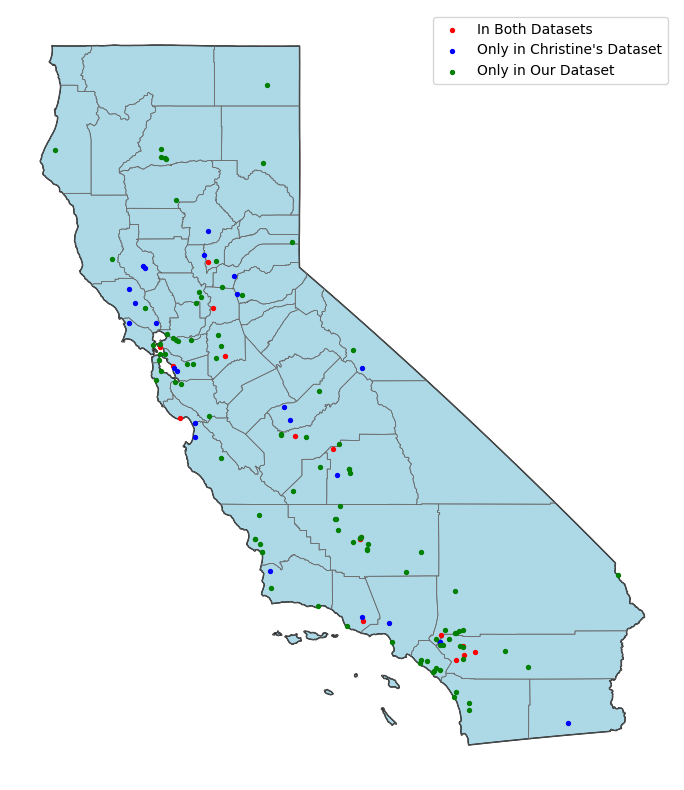

In [28]:
# plot the plants in three different colors
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_same.plot(ax=ax, marker='o', color='red', markersize=8, label='In Both Datasets')
gdf_only_christine.plot(ax=ax, marker='o', color='blue', markersize=8, label='Only in Christine\'s Dataset')
gdf_only_us.plot(ax=ax, marker='o', color='green', markersize=8, label='Only in Our Dataset')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

## Add census data

https://data.ca.gov/dataset/ca-geographic-boundaries\
https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-cities-and-towns.html\
https://catalog.data.gov/dataset/tiger-line-shapefile-2016-state-california-current-place-state-based

https://data.census.gov/table/ACSDT5YSPT2015.B19013?t=Income+(Households,+Families,+Individuals):Population+Total&g=040XX00US06$1600000\
Both in 2015:\
American Community Survey: B19013 MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS)\
American Community Survey: B01003 Total Population

In [29]:
gdf_CA_MCD = gpd.read_file('CA_2016_06_place')
gdf_CA_County = gpd.read_file('CA_Counties')

In [30]:
ca_pop = pd.read_csv('CA_pop.csv')
ca_pop = ca_pop.transpose()
ca_pop = ca_pop.reset_index()
ca_pop = ca_pop.iloc[1:]
ca_pop.columns = ['Name', 'population']
ca_pop.fillna(0, inplace=True)
ca_pop.loc[:, 'Name'] = ca_pop.loc[:, 'Name'].str.split(',').str[0]
ca_pop.loc[:, 'population'] = ca_pop.loc[:, 'population'].str.replace(',', '')
ca_pop['population'] = pd.to_numeric(ca_pop['population'], errors='coerce').fillna(0).astype(int)
ca_pop

,Name,population
1,Alameda city,78614
2,Alhambra city,85572
3,Anaheim city,350738
4,Antioch city,110542
5,Apple Valley town,72185
...,...,...
133,West Covina city,108489
134,Westminster city,92111
135,Whittier city,87436
136,Yorba Linda city,67966


In [31]:
ca_income = pd.read_csv('CA_income.csv')
ca_income = ca_income.transpose()
ca_income = ca_income.reset_index()
ca_income = ca_income.iloc[1:]
ca_income.columns = ['Name', 'income']
ca_income.loc[:, 'Name'] = ca_income.loc[:, 'Name'].str.split(',').str[0]
ca_income.income = ca_income.income.str.replace(',', '')
ca_income.income.fillna(0, inplace=True)
ca_income.income = ca_income.income.astype(int)
ca_income

,Name,income
1,Piñon Hills CDP,44984
2,Acalanes Ridge CDP,156953
3,Acton CDP,89150
4,Adelanto city,33298
5,Agoura Hills city,113658
...,...,...
1170,Yuba City city,50649
1171,Yucaipa city,56452
1172,Yucca Valley town,40030
1173,Zayante CDP,81513


In [32]:
# merge ca_pop and ca_income
ca_pop_income = pd.merge(ca_pop, ca_income, on='Name')

# merge with gdf_CA_MCD
gdf_CA_MCD_pop_income = pd.merge(gdf_CA_MCD, ca_pop_income, left_on='NAMELSAD', right_on='Name')
gdf_CA_MCD_pop_income

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Name,population,income
0,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,G4110,A,56500370,27033715,+34.2677796,-119.2542062,"MULTIPOLYGON (((-119.29710 34.34463, -119.2970...",San Buenaventura (Ventura) city,109717,66995
1,06,32548,02410720,0632548,Hawthorne,Hawthorne city,25,C1,N,N,G4110,A,15750339,28946,+33.9147753,-118.3480828,"POLYGON ((-118.37874 33.89872, -118.37874 33.8...",Hawthorne city,88444,44504
2,06,36546,02410106,0636546,Inglewood,Inglewood city,25,C1,N,N,G4110,A,23485845,63502,+33.9560678,-118.3442743,"MULTIPOLYGON (((-118.37625 33.98285, -118.3762...",Inglewood city,111656,42044
3,06,55156,02411359,0655156,Palmdale,Palmdale city,25,C1,N,N,G4110,A,274452754,633935,+34.5910383,-118.1054031,"POLYGON ((-118.28773 34.58140, -118.28770 34.5...",Palmdale city,158350,52392
4,06,69088,02411819,0669088,Santa Clarita,Santa Clarita city,25,C1,N,N,G4110,A,136645644,131952,+34.4029972,-118.5041658,"POLYGON ((-118.61346 34.44956, -118.61342 34.4...",Santa Clarita city,182367,83554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,06,81344,02412137,0681344,Upland,Upland city,25,C1,N,N,G4110,A,40460527,86983,+34.1160731,-117.6599224,"POLYGON ((-117.70449 34.09526, -117.70443 34.0...",Upland city,76447,60779
133,06,02553,02407756,0602553,Arden-Arcade,Arden-Arcade CDP,57,U2,Y,N,G4210,S,46185637,232743,+38.6033643,-121.3800518,"POLYGON ((-121.42050 38.57890, -121.42047 38.5...",Arden-Arcade CDP,96276,45489
134,06,11390,02407967,0611390,Carmichael,Carmichael CDP,57,U1,N,N,G4210,S,35028560,685947,+38.6348761,-121.3242187,"POLYGON ((-121.35207 38.58861, -121.35165 38.5...",Carmichael CDP,63215,54322
135,06,20802,02408711,0620802,East Los Angeles,East Los Angeles CDP,57,U1,N,N,G4210,S,19298247,11013,+34.0315059,-118.1685666,"POLYGON ((-118.19262 34.06176, -118.19254 34.0...",East Los Angeles CDP,119666,38766


In [33]:
from matplotlib.colors import LinearSegmentedColormap
# Define the colors
start_color = "#88CDF6"
end_color = "#015C92"
cmap = LinearSegmentedColormap.from_list("my_gradient", [start_color, end_color])


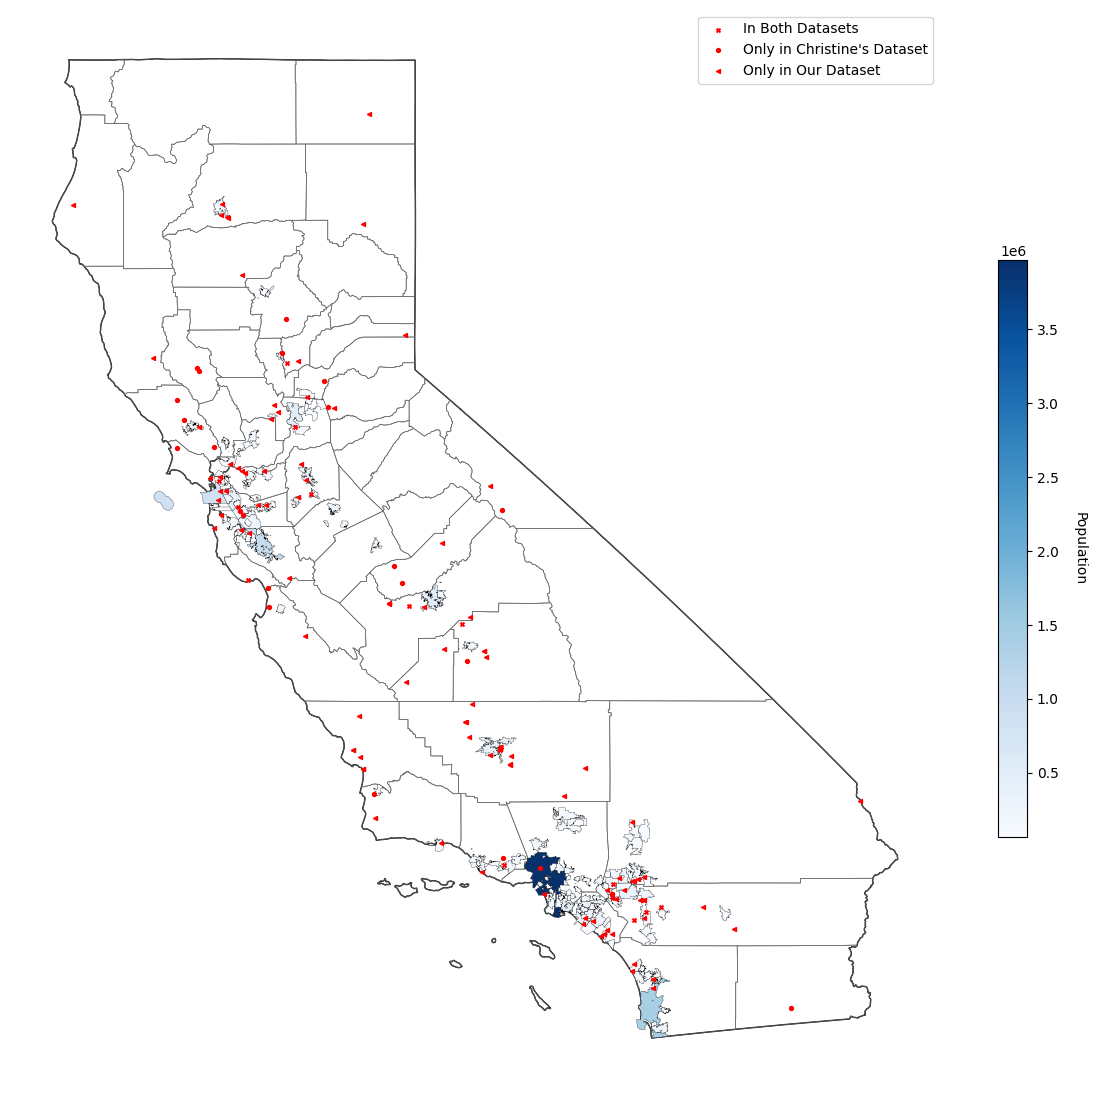

In [34]:
# plot the plants in three different markers, the background is the population
fig, ax = plt.subplots(figsize=(15, 15))
california.plot(ax=ax, facecolor='none', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_CA_MCD_pop_income.plot(ax=ax, column='population', cmap="Blues", edgecolor='black', linewidth=0.2)
gdf_same.plot(ax=ax, marker='x', color='red', markersize=8, label='In Both Datasets')
gdf_only_christine.plot(ax=ax, marker='o', color='red', markersize=8, label='Only in Christine\'s Dataset')
gdf_only_us.plot(ax=ax, marker='<', color='red', markersize=8, label='Only in Our Dataset')

# Adjust the legend and color bar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=gdf_CA_MCD_pop_income['population'].min(), vmax=gdf_CA_MCD_pop_income['population'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the shrink parameter as needed
cbar.set_label('Population', rotation=270, labelpad=20)

# Set title
plt.axis('off')
plt.legend()
plt.show()


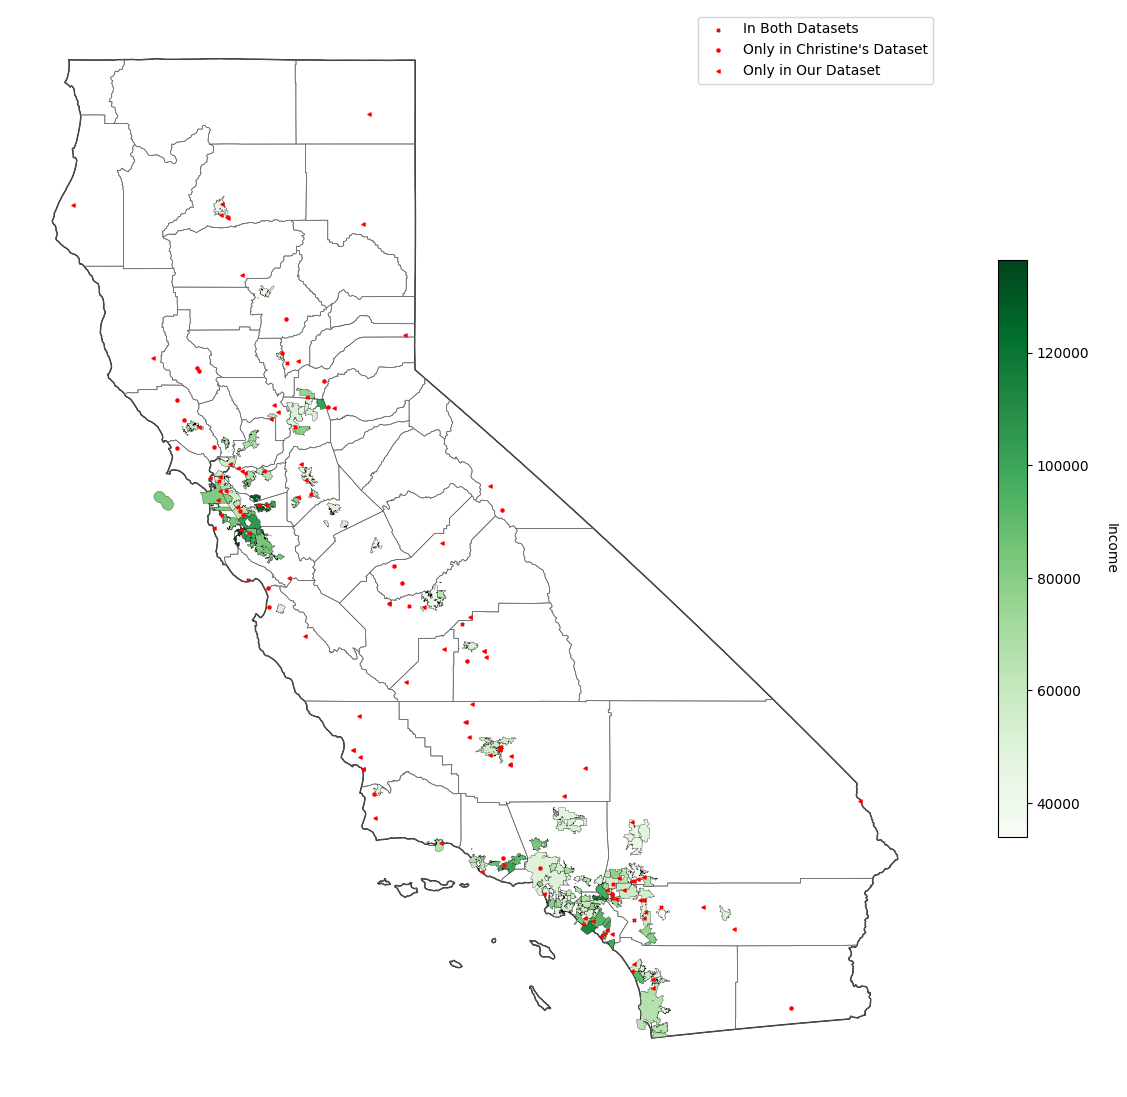

In [35]:
# plot the plants in three different markers, the background is the income
fig, ax = plt.subplots(figsize=(15, 15))
california.plot(ax=ax, facecolor='none', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_CA_MCD_pop_income.plot(ax=ax, column='income', cmap="Greens", edgecolor='black', linewidth=0.2)
gdf_same.plot(ax=ax, marker='x', color='red', markersize=5, label='In Both Datasets')
gdf_only_christine.plot(ax=ax, marker='o', color='red', markersize=5, label='Only in Christine\'s Dataset')
gdf_only_us.plot(ax=ax, marker='<', color='red', markersize=5, label='Only in Our Dataset')
# make the color lengend smaller

# Adjust the legend and color bar
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=gdf_CA_MCD_pop_income['income'].min(), vmax=gdf_CA_MCD_pop_income['income'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the shrink parameter as needed
cbar.set_label('Income', rotation=270, labelpad=20)

# Set title
plt.axis('off')
plt.legend()
plt.show()

In [36]:
# count how many points fall into each city
gdf_CA_MCD_pop_income['counts'] = gdf_CA_MCD_pop_income['geometry'].apply(lambda x: gdf_yes_centroid.within(x).sum())
gdf_CA_MCD_pop_income.counts.value_counts()

counts
0    98
1    32
2     5
3     1
6     1
Name: count, dtype: int64

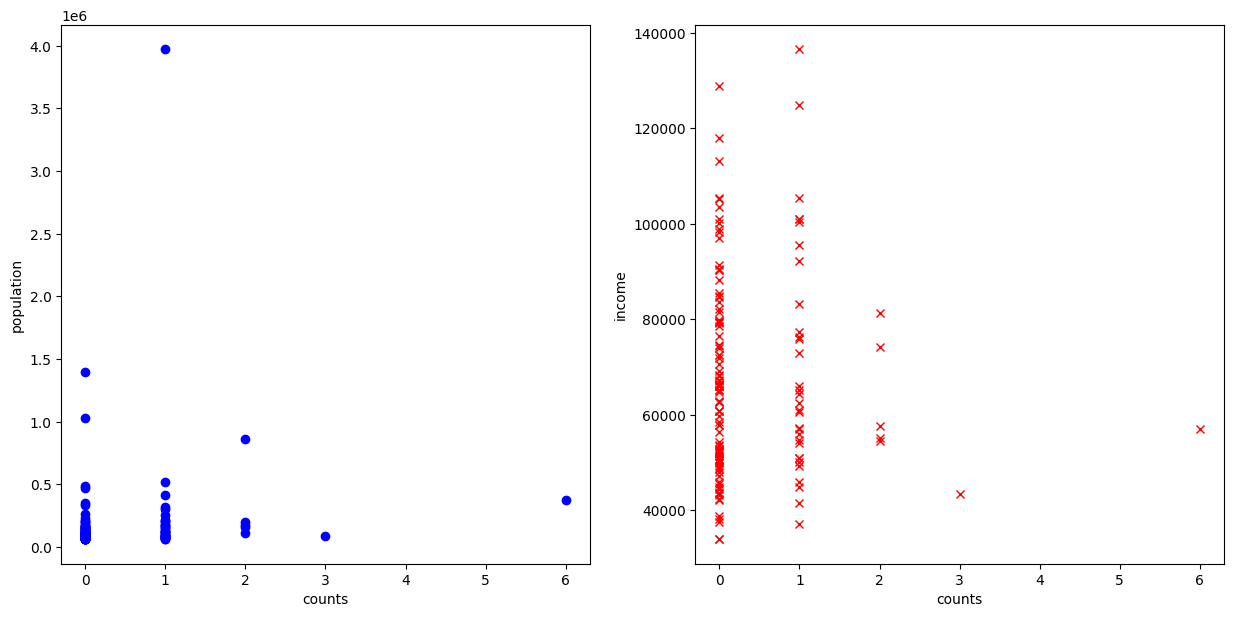

In [37]:
# plot the population and the counts, and the income and the counts in the same subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(gdf_CA_MCD_pop_income['counts'], gdf_CA_MCD_pop_income['population'], 'o', color='blue')
ax2.plot(gdf_CA_MCD_pop_income['counts'], gdf_CA_MCD_pop_income['income'], 'x', color='red')
ax1.set_xlabel('counts')
ax1.set_ylabel('population')
ax2.set_xlabel('counts')
ax2.set_ylabel('income')
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

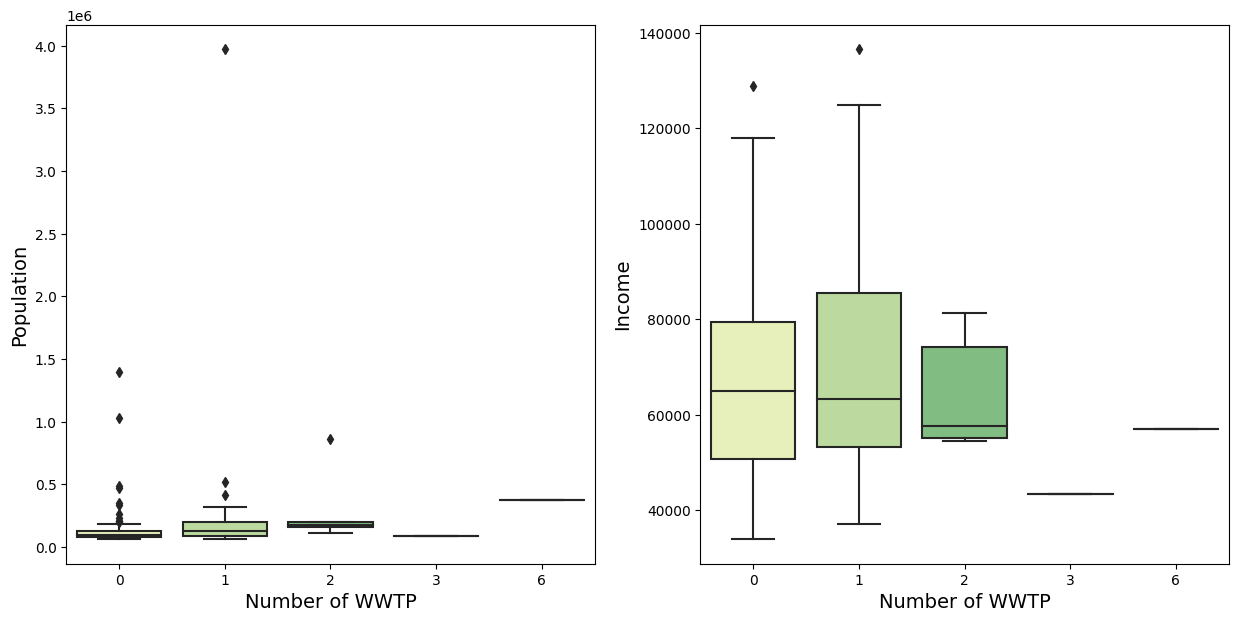

In [38]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Boxplot for counts vs population
sns.boxplot(x='counts', y='population', data=gdf_CA_MCD_pop_income, ax=ax1, palette="YlGn")
ax1.set_xlabel('Number of WWTP', fontsize=14)
ax1.set_ylabel('Population', fontsize=14)

# Boxplot for counts vs income
sns.boxplot(x='counts', y='income', data=gdf_CA_MCD_pop_income, ax=ax2, palette="YlGn")
ax2.set_xlabel('Number of WWTP', fontsize=14)
ax2.set_ylabel('Income', fontsize=14)

plt.show()

In [39]:
gdf_CA_MCD_pop_income

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Name,population,income,counts
0,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,...,A,56500370,27033715,+34.2677796,-119.2542062,"MULTIPOLYGON (((-119.29710 34.34463, -119.2970...",San Buenaventura (Ventura) city,109717,66995,0
1,06,32548,02410720,0632548,Hawthorne,Hawthorne city,25,C1,N,N,...,A,15750339,28946,+33.9147753,-118.3480828,"POLYGON ((-118.37874 33.89872, -118.37874 33.8...",Hawthorne city,88444,44504,0
2,06,36546,02410106,0636546,Inglewood,Inglewood city,25,C1,N,N,...,A,23485845,63502,+33.9560678,-118.3442743,"MULTIPOLYGON (((-118.37625 33.98285, -118.3762...",Inglewood city,111656,42044,0
3,06,55156,02411359,0655156,Palmdale,Palmdale city,25,C1,N,N,...,A,274452754,633935,+34.5910383,-118.1054031,"POLYGON ((-118.28773 34.58140, -118.28770 34.5...",Palmdale city,158350,52392,0
4,06,69088,02411819,0669088,Santa Clarita,Santa Clarita city,25,C1,N,N,...,A,136645644,131952,+34.4029972,-118.5041658,"POLYGON ((-118.61346 34.44956, -118.61342 34.4...",Santa Clarita city,182367,83554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,06,81344,02412137,0681344,Upland,Upland city,25,C1,N,N,...,A,40460527,86983,+34.1160731,-117.6599224,"POLYGON ((-117.70449 34.09526, -117.70443 34.0...",Upland city,76447,60779,0
133,06,02553,02407756,0602553,Arden-Arcade,Arden-Arcade CDP,57,U2,Y,N,...,S,46185637,232743,+38.6033643,-121.3800518,"POLYGON ((-121.42050 38.57890, -121.42047 38.5...",Arden-Arcade CDP,96276,45489,0
134,06,11390,02407967,0611390,Carmichael,Carmichael CDP,57,U1,N,N,...,S,35028560,685947,+38.6348761,-121.3242187,"POLYGON ((-121.35207 38.58861, -121.35165 38.5...",Carmichael CDP,63215,54322,0
135,06,20802,02408711,0620802,East Los Angeles,East Los Angeles CDP,57,U1,N,N,...,S,19298247,11013,+34.0315059,-118.1685666,"POLYGON ((-118.19262 34.06176, -118.19254 34.0...",East Los Angeles CDP,119666,38766,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


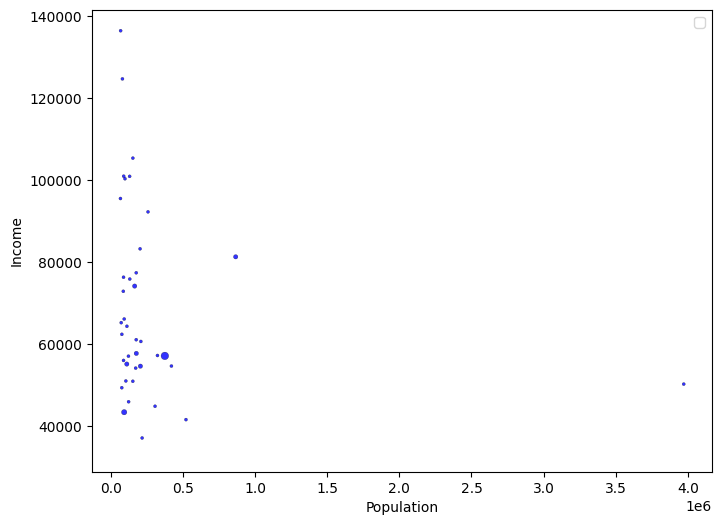

In [40]:
# plot population vs income, the size of the marker is the counts
fig, ax = plt.subplots(figsize=(8,6))

# Use scatter instead of plot
scatter = ax.scatter(gdf_CA_MCD_pop_income['population'], gdf_CA_MCD_pop_income['income'], 
                     c='blue', s=gdf_CA_MCD_pop_income['counts']*5, alpha=0.8, edgecolors='black', linewidths=0.2)

plt.xlabel('Population')
plt.ylabel('Income')
plt.legend()

plt.show()

## Texas plotting

In [41]:
texas = pd.read_csv('/workspaces/wastewater_treatment/WWTP_list_all_state/WWTP_Texas.csv', usecols=['WWTP_name', 'centroid'])
# turn dataframe to geodataframe
texas['centroid'] = texas['centroid'].apply(wkt.loads)
gdf_texas_all = gpd.GeoDataFrame(texas, geometry='centroid')
gdf_texas_all.crs = 'epsg:4326'
gdf_texas_all.head()

,WWTP_name,centroid
0,Plant_27449381,POINT (-96.77224 32.73390)
1,City of Leander Wastewater Treatment Plant,POINT (-97.84113 30.58042)
2,Plant_29415748,POINT (-97.82171 30.55485)
3,Plant_29660147,POINT (-97.79780 30.46284)
4,Albert H. Ullrich Water Treatment Plant,POINT (-97.79621 30.28999)


In [42]:
texas_yes_list = pd.read_csv('TX_Yes_list.csv')
texas_maybe_list = pd.read_csv('TX_Maybe_list.csv')
print(texas_yes_list.shape, texas_maybe_list.shape) 

# filter the gdf_texas_yes, gdf_texas_maybe
gdf_texas_yes = gdf_texas_all.loc[gdf_texas_all['WWTP_name'].isin(texas_yes_list['filename'])]
gdf_texas_maybe = gdf_texas_all.loc[gdf_texas_all['WWTP_name'].isin(texas_maybe_list['filename'])]
print(gdf_texas_yes.shape, gdf_texas_maybe.shape)

gdf_texas_yes_and_maybe = pd.concat([gdf_texas_yes, gdf_texas_maybe])

(198, 1) (104, 1)
(198, 2) (104, 2)


In [53]:
# gdf_texas_yes.to_csv('gdf_texas_yes.csv')
# gdf_texas_yes_and_maybe.to_csv('gdf_texas_yes_and_maybe.csv')

In [44]:
gdf_TX_city = gpd.read_file('TX_MCD')
gdf_TX_city.to_crs(epsg=4326, inplace=True)
gdf_TX_city.head()

,OBJECTID,GID,CITY_NM,TXDOT_CITY,CITY_FIPS,CNTY_SEAT_,POP1990,POP2000,POP2010,POP2020,POP_CD,MAP_COLOR_,COLOR_CD,SHAPE_Leng,SHAPE_Area,geometry
0,1,21,Spur,40550,4869848,N,1300.0,1088.0,1318.0,1167,1,1,1,0.218973,0.000397,"POLYGON ((-100.86058 33.44251, -100.86089 33.4..."
1,2,22,Runge,37050,4863788,N,1139.0,1080.0,1031.0,1166,1,1,1,0.081795,0.000293,"POLYGON ((-97.71744 28.87118, -97.72271 28.887..."
2,3,23,Lometa,25150,4843516,N,625.0,782.0,856.0,874,1,1,1,0.114231,0.000221,"POLYGON ((-98.39270 31.20650, -98.39270 31.206..."
3,4,24,Eden,12800,4822552,N,1567.0,2561.0,2766.0,1339,1,1,1,0.116755,0.000555,"POLYGON ((-99.82527 31.20487, -99.84261 31.204..."
4,5,25,Leona,24330,4842340,N,178.0,181.0,175.0,179,1,1,1,0.131349,0.000465,"POLYGON ((-95.99846 31.14166, -96.00018 31.144..."


In [45]:
tx_pop = pd.read_csv('TX_pop.csv')
tx_pop = tx_pop.transpose()
tx_pop = tx_pop.reset_index()
tx_pop = tx_pop.iloc[1:]
tx_pop.columns = ['Name', 'population']
tx_pop.fillna(0, inplace=True)
tx_pop.loc[:, 'Name'] = tx_pop.loc[:, 'Name'].str.split(',').str[0]
tx_pop.loc[:, 'population'] = tx_pop.loc[:, 'population'].str.replace(',', '')
tx_pop['population'] = pd.to_numeric(tx_pop['population'], errors='coerce').fillna(0).astype(int)

tx_income = pd.read_csv('TX_income.csv')
tx_income = tx_income.transpose()
tx_income = tx_income.reset_index()
tx_income = tx_income.iloc[1:]
tx_income.columns = ['Name', 'income']
tx_income.loc[:, 'Name'] = tx_income.loc[:, 'Name'].str.split(',').str[0]
tx_income.income = tx_income.income.str.replace(',', '')
tx_income.income.fillna(0, inplace=True)
tx_income.income = tx_income.income.astype(int)

# merge tx_pop and tx_income
tx_pop_income = pd.merge(tx_pop, tx_income, on='Name')
# get rid of the last word in Name
tx_pop_income['Name'] = tx_pop_income['Name'].str.split(' ').str[:-1].str.join(' ')
tx_pop_income.head()

,Name,population,income
0,Abilene,125876,43189
1,Allen,98138,103051
2,Amarillo,199651,47735
3,Arlington,388122,53326
4,Atascocita,78240,84982


In [46]:
# merge with gdf_TX_city
gdf_TX_city_pop_income = pd.merge(gdf_TX_city, tx_pop_income, left_on='CITY_NM', right_on='Name')
gdf_TX_city_pop_income.head()

,OBJECTID,GID,CITY_NM,TXDOT_CITY,CITY_FIPS,CNTY_SEAT_,POP1990,POP2000,POP2010,POP2020,POP_CD,MAP_COLOR_,COLOR_CD,SHAPE_Leng,SHAPE_Area,geometry,Name,population,income
0,194,172,Edinburg,12950,4822660,Y,29885.0,48465.0,77100.0,102374,4,4,4,0.971712,0.010470,"POLYGON ((-98.12209 26.30276, -98.12235 26.301...",Edinburg,84501,43346
1,386,454,Pearland,31490,4854528,N,912.0,1192.0,1111.0,123562,4,3,3,1.728683,0.011728,"POLYGON ((-95.28413 29.59773, -95.28403 29.597...",Pearland,111665,95972
2,436,517,Pasadena,32000,4856000,N,119363.0,141674.0,149043.0,149440,4,4,4,0.877307,0.014305,"POLYGON ((-95.14722 29.72902, -95.14720 29.729...",Pasadena,153786,48004
3,603,1138,El Paso,13400,4824000,Y,515342.0,563662.0,649121.0,681534,4,1,1,2.472756,0.064048,"POLYGON ((-106.56859 31.96042, -106.56862 31.9...",El Paso,681136,42772
4,604,1158,Round Rock,36750,4863500,N,30923.0,61136.0,99887.0,137575,4,2,2,1.673815,0.009367,"POLYGON ((-97.60326 30.57731, -97.60242 30.575...",Round Rock,115839,72412


/home/codespace/.python/current/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


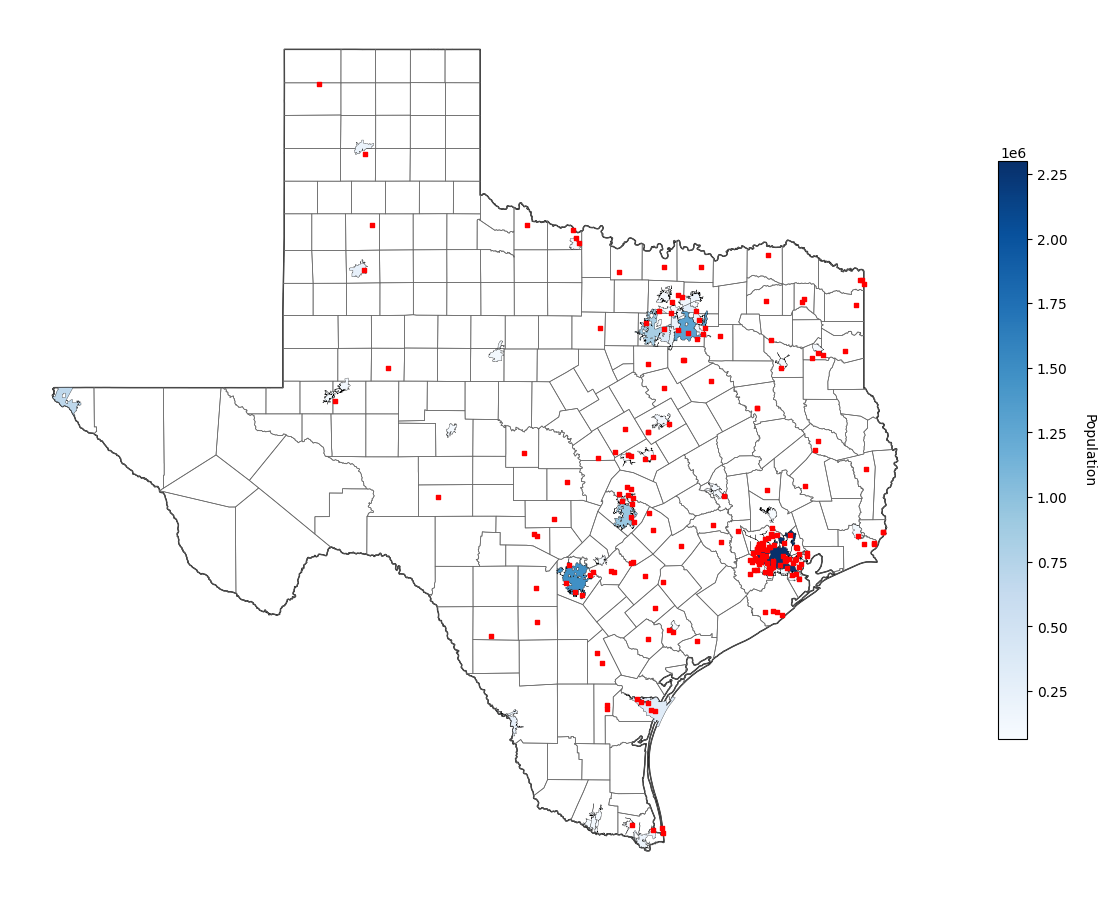

In [56]:
# URLs to shapefiles
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_5m.zip'
url_counties = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip'

# Load data
states = gpd.read_file(url_state)
counties = gpd.read_file(url_counties)

# Filter for California and its counties and places
texas = states[states['STUSPS'] == 'TX']
tx_counties = counties[counties['STATEFP'] == '48']
texas.to_crs(epsg=4326, inplace=True)
tx_counties.to_crs(epsg=4326, inplace=True)

# Plot Christine's data
fig, ax = plt.subplots(figsize=(15, 15))
texas.plot(ax=ax, facecolor='none', edgecolor='black')
tx_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_TX_city_pop_income.plot(ax=ax, column='population', cmap="Blues", edgecolor='black', linewidth=0.2)
gdf_texas_yes.plot(ax=ax, marker='s', color='red', markersize=5, label='Verified WWTPs')
# gdf_texas_maybe.plot(ax=ax, marker='s', color='orange', markersize=5, label='Potential WWTPs')

# Adjust the legend and color bar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=gdf_TX_city_pop_income['population'].min(), vmax=gdf_TX_city_pop_income['population'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the shrink parameter as needed
cbar.set_label('Population', rotation=270, labelpad=20)

# Set title
plt.axis('off')
# plt.legend()
plt.show()

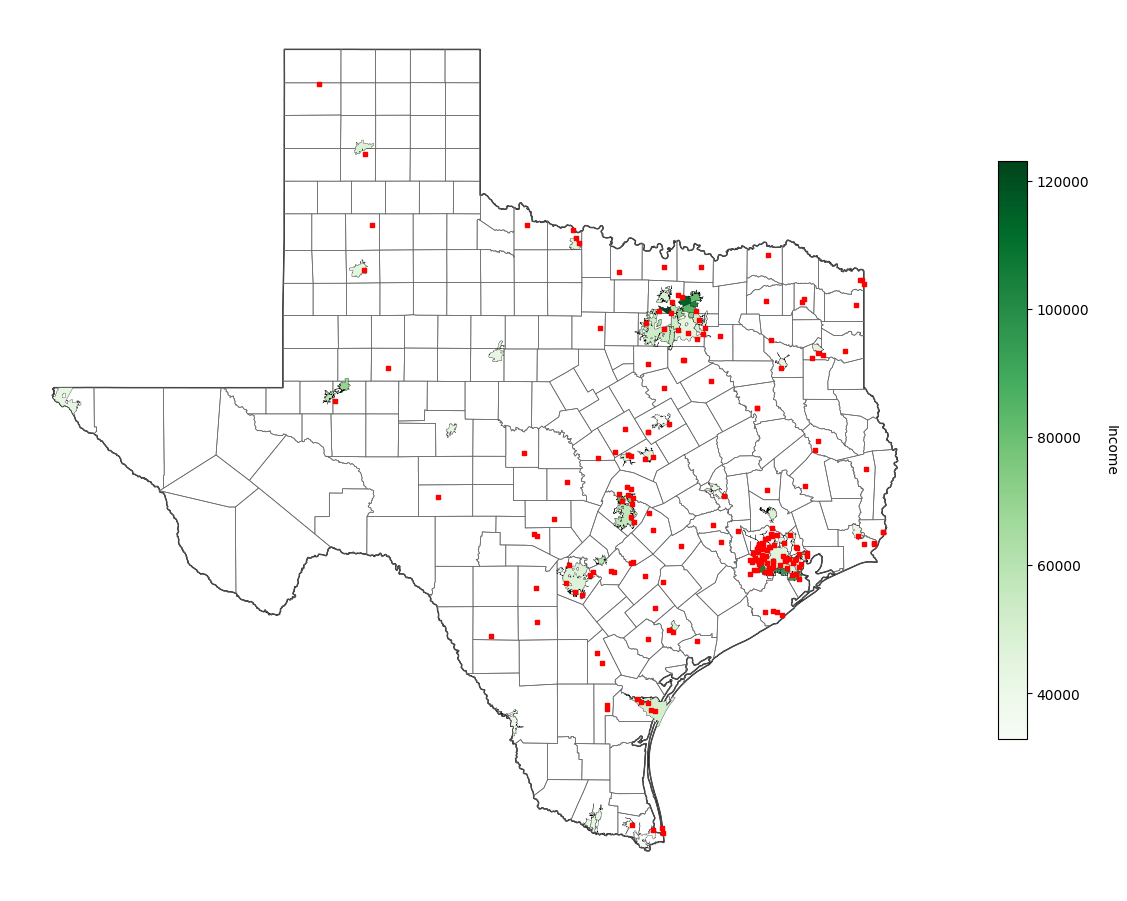

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
texas.plot(ax=ax, facecolor='none', edgecolor='black')
tx_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_TX_city_pop_income.plot(ax=ax, column='income', cmap="Greens", edgecolor='black', linewidth=0.2)
gdf_texas_yes.plot(ax=ax, marker='s', color='red', markersize=5, label='Verified WWTPs')

# Adjust the legend and color bar
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=gdf_TX_city_pop_income['income'].min(), vmax=gdf_TX_city_pop_income['income'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the shrink parameter as needed
cbar.set_label('Income', rotation=270, labelpad=20)

# Set title
plt.axis('off')
# plt.legend()
plt.show()

In [49]:
# count how many points fall into each city
gdf_TX_city_pop_income['counts'] = gdf_TX_city_pop_income['geometry'].apply(lambda x: gdf_texas_yes.within(x).sum())
gdf_TX_city_pop_income.counts.value_counts()

counts
0     29
1     16
2      4
3      3
4      2
16     1
Name: count, dtype: int64

In [57]:
gdf_TX_city_pop_income['counts_yes_and_maybe'] = gdf_TX_city_pop_income['geometry'].apply(lambda x: gdf_texas_yes_and_maybe.within(x).sum())
gdf_TX_city_pop_income.counts_yes_and_maybe.value_counts()

counts_yes_and_maybe
0     22
1     19
3      4
2      4
4      3
5      1
19     1
12     1
Name: count, dtype: int64

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

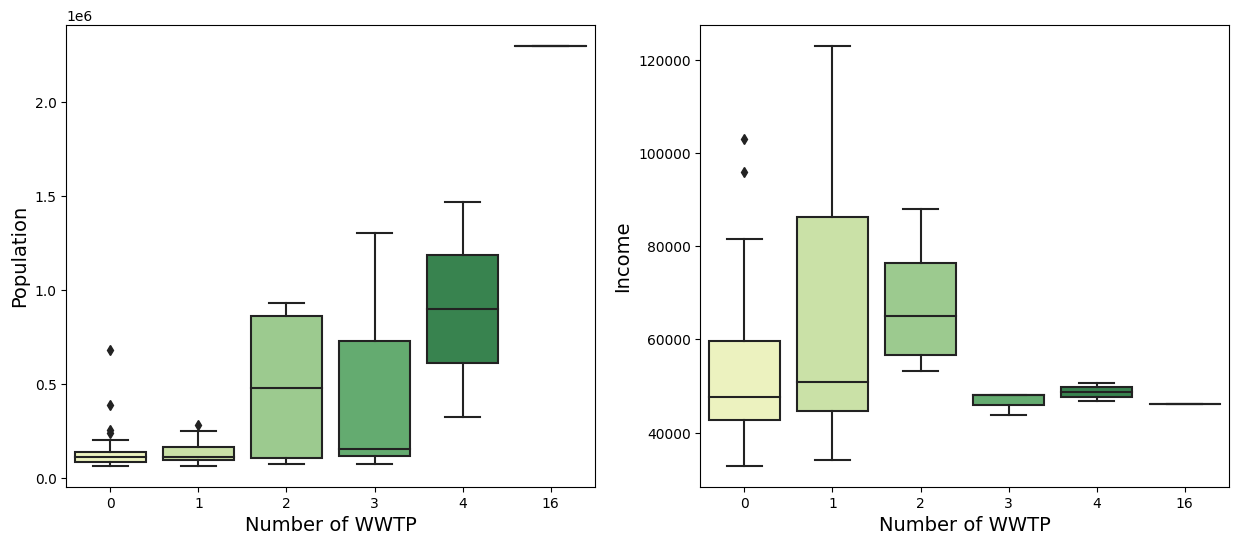

In [51]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Boxplot for counts vs population
sns.boxplot(x='counts', y='population', data=gdf_TX_city_pop_income, ax=ax1, palette="YlGn")
ax1.set_xlabel('Number of WWTP', fontsize=14)
ax1.set_ylabel('Population', fontsize=14)

# Boxplot for counts vs income
sns.boxplot(x='counts', y='income', data=gdf_TX_city_pop_income, ax=ax2, palette="YlGn")
ax2.set_xlabel('Number of WWTP', fontsize=14)
ax2.set_ylabel('Income', fontsize=14)
plt.show()


/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

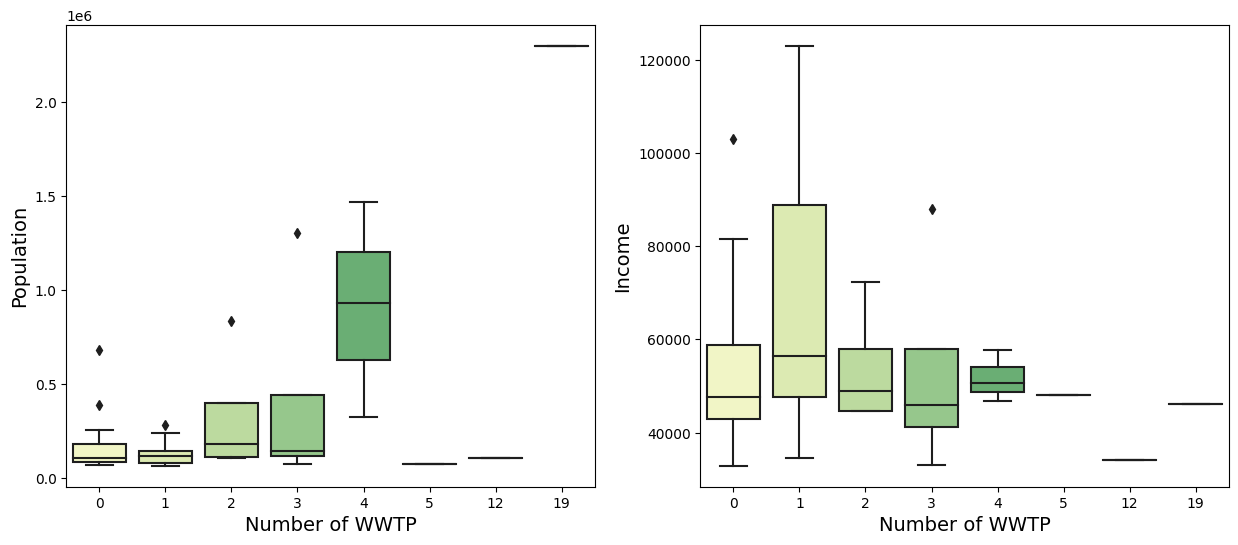

In [58]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Boxplot for counts vs population
sns.boxplot(x='counts_yes_and_maybe', y='population', data=gdf_TX_city_pop_income, ax=ax1, palette="YlGn")
ax1.set_xlabel('Number of WWTP', fontsize=14)
ax1.set_ylabel('Population', fontsize=14)

# Boxplot for counts vs income
sns.boxplot(x='counts_yes_and_maybe', y='income', data=gdf_TX_city_pop_income, ax=ax2, palette="YlGn")
ax2.set_xlabel('Number of WWTP', fontsize=14)
ax2.set_ylabel('Income', fontsize=14)
plt.show()

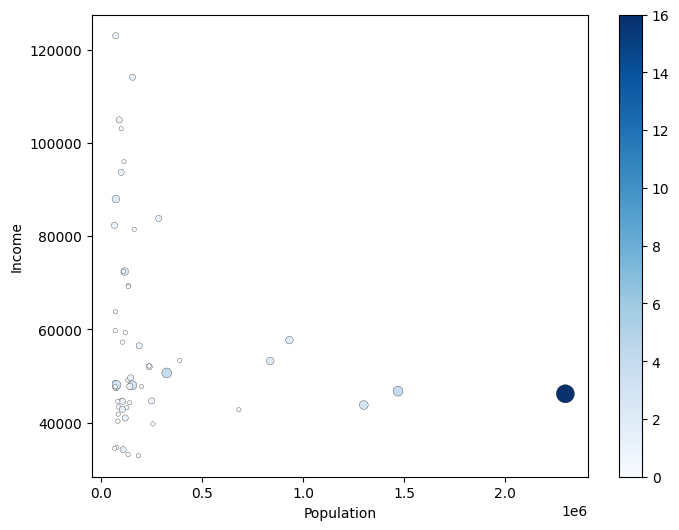

In [52]:
# plot population vs income, the size of the marker is the counts
fig, ax = plt.subplots(figsize=(8, 6))

# Use scatter instead of plot
scatter = ax.scatter(gdf_TX_city_pop_income['population'], gdf_TX_city_pop_income['income'], 
                     c=gdf_TX_city_pop_income['counts'],cmap="Blues",
                     s=(gdf_TX_city_pop_income['counts']+1)*10, edgecolor='black', linewidth=0.2)

plt.xlabel('Population')
plt.ylabel('Income')
# show the color bar
cbar = fig.colorbar(scatter, ax=ax)
# cbar.set_label('Number of WWTP', rotation=0, x=-1, labelpad=20)

# Define representative counts and corresponding sizes
# representative_counts = [0, 1, 2, 3, 12]  # Example counts
# sizes = [(count + 1) * 10 for count in representative_counts]  # Calculate sizes

# # Create custom legend
# legend_markers = [plt.scatter([], [], s=size, edgecolor='black', color='blue', alpha=0.8, label=str(count))
#                   for size, count in zip(sizes, representative_counts)]

# plt.legend(handles=legend_markers, title='Number of WWTP', loc='upper right')

plt.show()

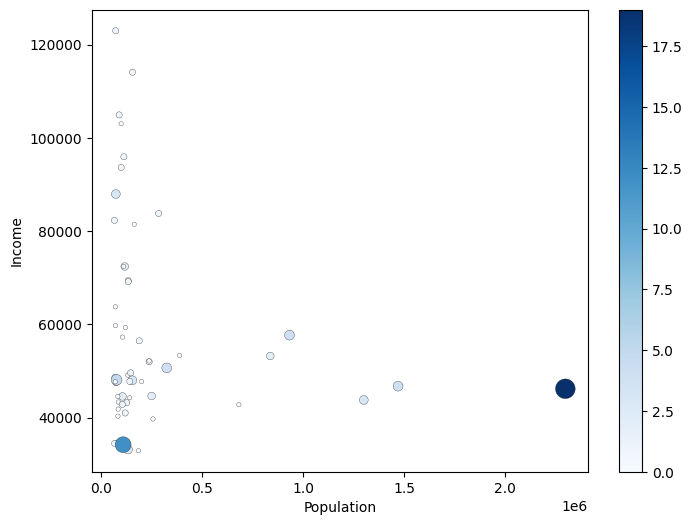

In [59]:
# plot population vs income, the size of the marker is the counts
fig, ax = plt.subplots(figsize=(8, 6))

# Use scatter instead of plot
scatter = ax.scatter(gdf_TX_city_pop_income['population'], gdf_TX_city_pop_income['income'], 
                     c=gdf_TX_city_pop_income['counts_yes_and_maybe'],cmap="Blues",
                     s=(gdf_TX_city_pop_income['counts_yes_and_maybe']+1)*10, edgecolor='black', linewidth=0.2)

plt.xlabel('Population')
plt.ylabel('Income')
# show the color bar
cbar = fig.colorbar(scatter, ax=ax)
# cbar.set_label('Number of WWTP', rotation=0, x=-1, labelpad=20)

# Define representative counts and corresponding sizes
# representative_counts = [0, 1, 2, 3, 12]  # Example counts
# sizes = [(count + 1) * 10 for count in representative_counts]  # Calculate sizes

# # Create custom legend
# legend_markers = [plt.scatter([], [], s=size, edgecolor='black', color='blue', alpha=0.8, label=str(count))
#                   for size, count in zip(sizes, representative_counts)]

# plt.legend(handles=legend_markers, title='Number of WWTP', loc='upper right')

plt.show()